In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import lightgbm

import optuna.integration as opt
import optuna.integration.lightgbm as lgb_tuner
import optuna

import datetime as dt

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format
from utils.plotting import *
from src.src import *

In [4]:
# Load data
data_len = 1560

df_w = load_data(file_name=f"df_weekly_{data_len}.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name=f"dict_weekly_{data_len}.pkl", file_path=WORK_DATA_DIR)

In [43]:
# predicted is y col
data_dict["model_features"].update(predicted="sp_close_lead5")

# Model features

In [44]:
# select model features
cols = [item for item in data_dict["data"]["relevant_cols"] if "lead" not in item]
cols = [
    'vixo',
     # 'naaim_ind',
     # 'naaim_max',
     # 'naaim_q1',
     'ff_M_RF',
     'ff_SMB',
     'ff_HML',
     'ff_RMW',
     'ff_CMA',
     'termspread',
     # 'pc_ratio',
     'aaii_Bullish',
     'aaii_Bearish',
     'aaii_Neutral',
     'sp_close',
     'sp_close_lag1',
     'sp_close_lag2',
     'sp_close_lag3',
     'sp_close_lag4',
     'sp_close_lag5',
     'sp_close_lag6',
     'sp_close_lag7',
]

# predictors are all X cols
data_dict["model_features"].update(predictor=[item for item in cols if item != data_dict["model_features"]["predicted"]])

In [45]:
df_ws = df_w[cols + [data_dict["model_features"]["predicted"]]].copy()

# Cross corr

In [46]:
df_cross_corr(df_ws,
              # cols,
              [item for item in cols if item not in data_dict["data"]["sp_cols"]],
              data_dict["model_features"]["predicted"],
              show_plot=False,
              no_lags=20,
              figsize=(6, 3))

[['vixo', 0, 0.052],
 ['ff_M_RF', 2, 0.053],
 ['ff_SMB', 10, 0.07],
 ['ff_HML', 14, 0.098],
 ['ff_RMW', 11, 0.065],
 ['ff_CMA', 14, 0.058],
 ['termspread', 3, 0.053],
 ['aaii_Bullish', 16, 0.054],
 ['aaii_Bearish', 14, 0.076],
 ['aaii_Neutral', 10, 0.065]]

In [47]:
df_ws, _ = shift_var_relative_to_df(df_ws,
                                 shift_var=["ff_SMB"],
                                 no_lags=[4])
data_dict["data_transformation"].update(shift_var=_)
df_ws = df_ws.dropna()

# Multi corr

,VIF,corr_sp_close_lead5
sp_close,8.695066,-0.077570
ff_HML,1.400708,-0.061012
sp_close_lag1,9.370378,-0.049390
ff_CMA,1.556484,-0.042918
sp_close_lag2,4.589267,-0.034048
ff_SMB,1.020873,-0.033299
termspread,1.043431,-0.026929
ff_M_RF,3.157137,-0.014141
aaii_Neutral,2.596749,-0.014005
aaii_Bearish,3.896532,0.005368


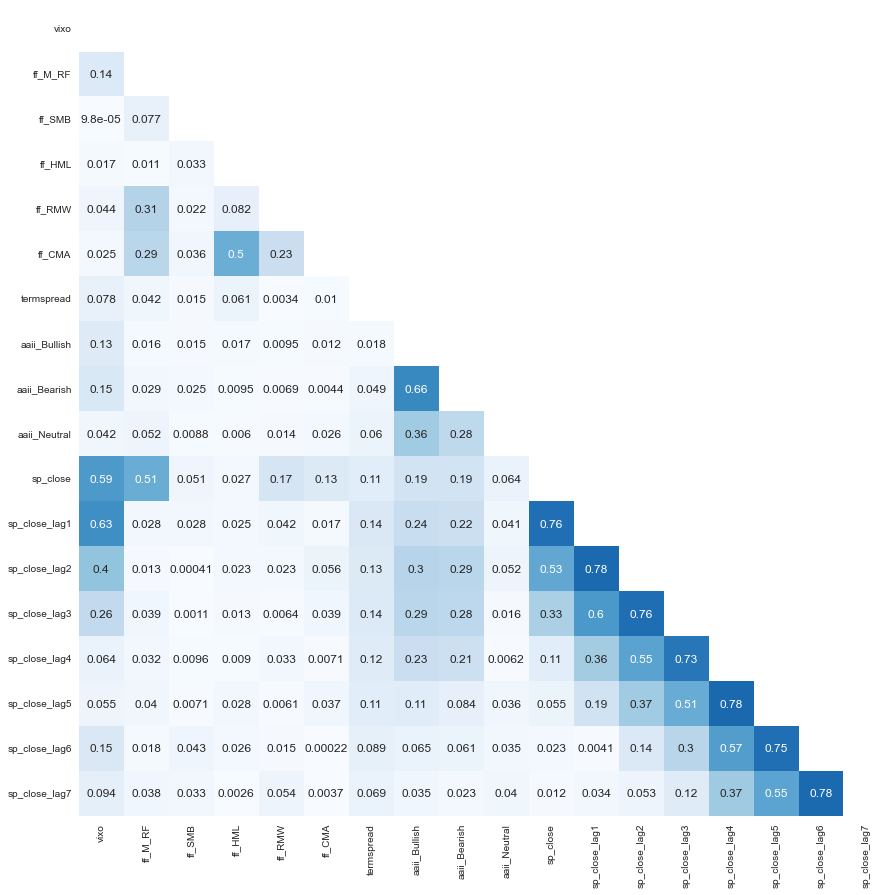

In [48]:
# only rely on correlation not vif
corr_heatmap(df_ws, 
             cols,
             show_fig=True)
get_variance_inflation_factor(df_ws, cols, col_pred=data_dict["model_features"]["predicted"])

# tts & standard scaling

In [49]:
df_train = df_ws.copy()

In [50]:
X_train, X_test, y_train, y_test = tts_data(df_train, 
                                            y=data_dict["model_features"]["predicted"],
                                            x=cols,
                                            add_const=False,
                                            random_split=False,
                                            test_size=.2)

In [51]:
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler_x.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler_x.transform(X_test), columns=X_test.columns)

In [52]:
data_dict["data_transformation"].update(standard_scaling={"scaled_cols": data_dict["model_features"]["predictor"],
                                                          "scaler_x": scaler_x})

# Tuner

In [53]:
tuner_params = {
    'objective': 'regression',
    'metric': ['log_loss', 'l2'],
    'random_state': random_state
}

tuner_train = lightgbm.Dataset(X_train, y_train)
tuner_eval = lightgbm.Dataset(X_test, y_test, reference=tuner_train)
tuner_eval_results = {}
training_time = 60 * 2

In [54]:
%%capture
my_study = optuna.study.create_study()

t_start = dt.datetime.now()
tuner = lgb_tuner.LightGBMTuner(tuner_params,
                                tuner_train,
                                valid_sets=tuner_eval,
                                study=my_study,
                                num_boost_round=1000,
                                time_budget=training_time,
                                callbacks=[lightgbm.early_stopping(100000), lightgbm.record_evaluation(tuner_eval_results)]
                               )
tuner.run()
t_end = dt.datetime.now()

[I 2022-03-13 20:40:56,197] A new study created in memory with name: no-name-1e07ef5b-c243-444a-89b0-cba74dd3a5fc
[I 2022-03-13 20:40:58,703] Trial 0 finished with value: 0.0005500863416933565 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.0005500863416933565.
[I 2022-03-13 20:41:00,828] Trial 1 finished with value: 0.0005488540205191684 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.0005488540205191684.
[I 2022-03-13 20:41:03,408] Trial 2 finished with value: 0.0005488540205191684 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.0005488540205191684.
[I 2022-03-13 20:41:05,888] Trial 3 finished with value: 0.0005488540205191684 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.0005488540205191684.
[I 2022-03-13 20:41:08,302] Trial 4 finished with value: 0.0005488540205191684 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.0005488540205191684.
[I 202

In [55]:
print(f'Parameters where tuned for {t_end - t_start}')
print(f'Max training time was {training_time}')

Parameters where tuned for 0:02:02.268162
Max training time was 120


In [56]:
tuner.best_params

{'objective': 'regression',
 'metric': ['log_loss', 'l2'],
 'random_state': 101,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 31,
 'feature_fraction': 1.0,
 'bagging_fraction': 0.6654319485899407,
 'bagging_freq': 2,
 'min_child_samples': 20}

In [57]:
params = {'objective': 'regression',
 'metric': ['log_loss', 'l2'],
 'random_state': 101,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 31,
 'feature_fraction': 1.0,
 'bagging_fraction': 0.6654319485899407,
 'bagging_freq': 2,
 'min_child_samples': 20}

# Model

In [58]:
lgb_train = lightgbm.Dataset(X_train, y_train)
lgb_test = lightgbm.Dataset(X_test, y_test, reference=lgb_train)
evals_result = {} 

In [59]:
%%capture
model = lightgbm.train(params,
                           lgb_train,
                           num_boost_round=250,
                           valid_sets=[lgb_test, lgb_train],
                           callbacks=[lightgbm.early_stopping(100000), lightgbm.record_evaluation(evals_result)])
data_dict["model_features"].update(params=params)

# Model eval

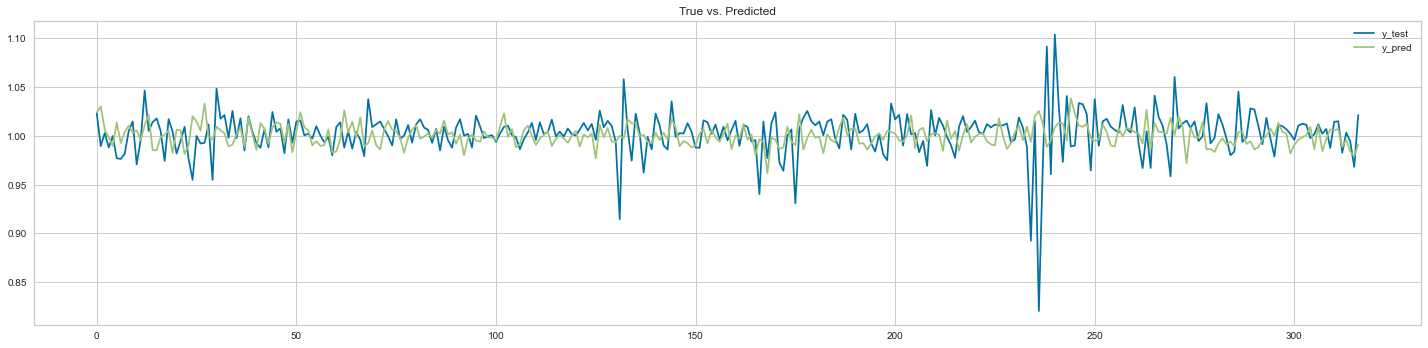

Validation Scores
mean squared error: 0.000639
mean absolute error: 0.017213
R2: -0.214422


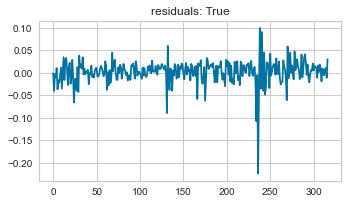

Stationarity Test Results
P-Values: 4.61979392519261e-16
Test-stats: -9.450887550999099
Time series is stationary: True


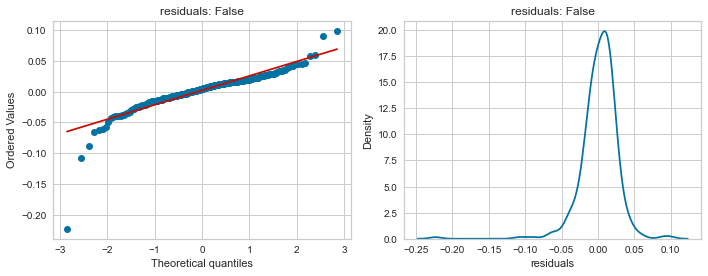

Normality Test Results
P-Values: 1.3709161436902745e-47
Test-stats: 215.81204027270056
Series is normally distributed: False
HET WHITE TEST REQUIRES A CONSTANT IN X DATA
adding constant to data


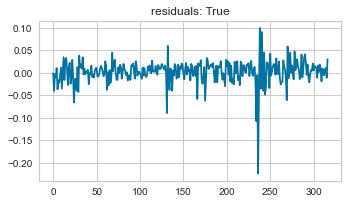

Test for Heteroskedasticity
Test p-value: 6.814927536480274e-07
Heteroskedasticity is present: True


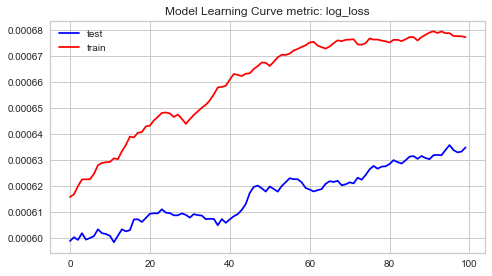

In [60]:
lgb_eval = ModelValidation(X_train=X_train,
                           y_train=y_train,
                           X_validate=X_test,
                           y_validate=y_test,
                           model=model)

lgb_eval.get_model_performance()
stat, norm, hetero = lgb_eval.analyse_resids(print_results=True)
lgb_eval.lgbm_learning_curve(params, lgb_train, lgb_test, "Model Learning Curve")

#update dict
# residuals
data_dict["model_metrics"].update(resid_stationarity=stat)
data_dict["model_metrics"].update(resid_normality=norm)
data_dict["model_metrics"].update(resid_heterskedasticity=hetero)

# model performance
data_dict["model_metrics"].update(mse=lgb_eval.mse)
data_dict["model_metrics"].update(mae=lgb_eval.mae)
data_dict["model_metrics"].update(r2=lgb_eval.r2)
data_dict["model_metrics"].update(residuals=lgb_eval.resid_inv)

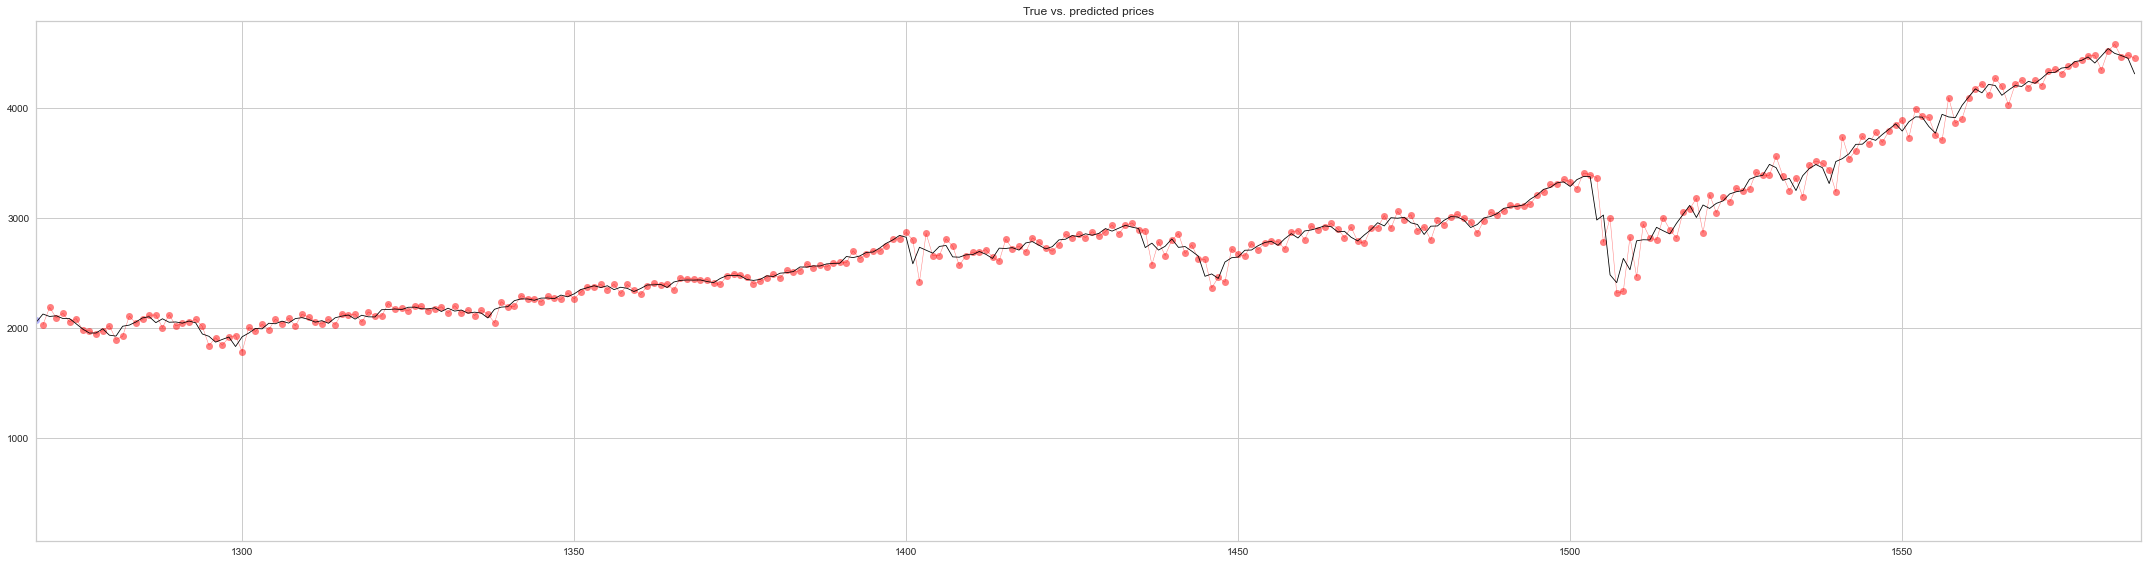

Validation Scores Test Data
mean squared error: 7188.13882
mean absolute error: 56.153761
mean absolute error in %: 0.039911372842258444
r2: 0.983407


In [22]:
lgb_eval.plot_results_on_price_scale(df_w,
                                 df_ws,
                                 sp_true_vals=data_dict["data"]["sp_true_vals"],
                                 show_pred_only=True)

# Save model

In [23]:
save_model(df_train, model, data_dict, name=f"lgb_{data_len}_{data_dict['model_features']['predicted']}", file_path=OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-03-13_lgb_1560_sp_close_lead1_model.pkl"? (y/n)


 y
